<a href="https://colab.research.google.com/github/olgOk/Adaptive_QNG/blob/dev_olga/TIF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install qiskit 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 37.5 MB/s 
     |████████████████████████████████| 12.8 MB 53.7 MB/s 
     |████████████████████████████████| 240 kB 57.8 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 106 kB 86.1 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 929 kB 53.4 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 37.5 MB 485 kB/s 
     |████████████████████████████████| 4.0 MB 48.2 MB/s 
     |████████████████████████████████| 1.9 MB 37.3 MB/s 
     |████████████████████████████████| 112 kB 58.3 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=75e806c33213641d7b6428bc789afaef9c441d20566b99656122c2f514ccd8d0
  Stored in directory: /root/.cache/pip/wheels/40/2c/d7/aa0

In [2]:
!python3 -m pip install qiskit_ibm_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 190 kB 29.0 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 237 kB 49.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 140 kB 46.9 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.30.2-py3-none-any.whl size=251991 sha256=f92d7e4420f7bdec56a419542d3af1a3a22d28b5f2e15b88a7c0dd302c2a9836
  Stored in directory: /root/.cache/pip/wheels/d0/18/32/cf13b0245c4d953cc0074b616c86f80751a6050d826ba75e27
Successfully built ibm-platform-services
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

In [3]:
!python3 -m pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 25.6 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=4bc9041bed0d9036991458e6f584027aa8d0e4faeb72aa1f5bce1435c011f5df
  Stored in directory: /root/.cache/pip/wheels/72/99/be/81d9bcdf5dd5ee5acd8119a9dd5bc07204c9ce205fd341b021
Successfully built pylatexenc


In [159]:
# imports
import time
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit.tools.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
# %config InlineBackend.figure_format='retina'

Prepare Hamiltonian using Qiskit [SparsePauliOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html)

$H = 0.4Z_1I_2 + 0.4I_1Z_2 + 0.2X_1X_2 = 0.4(Z_1I_2 + I_1Z_2) +  0.2X_1X_2$

## Using Qiskit opflow

In [76]:
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP, GradientDescent, AQGD
from qiskit.circuit.library import TwoLocal
from qiskit.opflow.gradients import Gradient, NaturalGradient
from qiskit.opflow import X, Z, I
from qiskit.utils import algorithm_globals
import matplotlib.pyplot as plt

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=800, seed_simulator=99)

Prepare Hamiltonian using [Qiskit Opflow Operators](https://qiskit.org/documentation/apidoc/opflow.html)

$H = 0.4Z_1I_2 + 0.4I_1Z_2 + 0.2X_1X_2 = 0.4(Z_1I_2 + I_1Z_2) +  0.2X_1X_2$

In [6]:
H_model = (0.4 * I ^ Z) + (0.4 * Z ^ I) + (0.2 * X ^ X)

## Anzatz 

Create an ansatz using Qiskit [RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) with 2 qubits and 1 repetition of rotation gates.
The total number of parameters is $2×(1+1) = 4$ (e.g. 2qubits 1 repetition)

In [7]:
seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

# define ansatz as RealAmplitude as described in research paper
ansatz = RealAmplitudes(2, reps=1)

Use [AQGD (Adaptive Quantum Gradient Descent)](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/aqgd.py) avaliable in the qiskit.optimizers module. 

In [ ]:
optimizer = AQGD(maxiter=1000)
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(H_model)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 603,
    'eigenstate': array([ 1.21998810e-01+0.j,  7.56421064e-05+0.j,  6.35416609e-05+0.j,
       -9.92530242e-01+0.j]),
    'eigenvalue': (-0.8246210581923005+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.5291274333129374,
                              ParameterVectorElement(θ[3]): -2.0116764950642048,
                              ParameterVectorElement(θ[1]): -1.070411480977584,
                              ParameterVectorElement(θ[2]): 2.6676670333594297},
    'optimal_point': array([-0.52912743, -1.07041148,  2.66766703, -2.0116765 ]),
    'optimal_value': -0.8246210581923005,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.6475479602813721}


# Transverse Field Ising Model

Fix the value of the parameter t, $t=0.1$, while vary the value of the parameter N, $N$ is in the interval $ [2, 10 ] $.

In [15]:
#N = 2, t = 0.1

t = 0.1

TFI_model = -1*(( I ^ Z ^ Z) + ( Z ^ Z ^ I)) +  t * ((I ^ I ^ X)  + (I ^ X ^ I))


# N = 3, t = 0.1 

# TFI_model = -1*((I ^ I ^ Z ^ Z) + (I ^ Z ^ Z ^ I) + (Z ^ Z ^ I ^ I) +  0.1 * (I^I^I ^ X) + 0.1 * (I^I^X ^ I) + 0.1 * (I ^ X ^ I ^ I))

A test run for the $N=2$.

In [17]:
ansatz = RealAmplitudes(3, reps=1)
optimizer = AQGD(maxiter=1000)
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(TFI_model)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 260,
    'eigenstate': array([ 1.24198317e-08+0.j, -2.40018812e-07+0.j, -8.12572852e-09+0.j,
        1.50796688e-07+0.j,  3.73195687e-03+0.j, -2.50073429e-02+0.j,
       -4.99204826e-02+0.j,  9.98433098e-01+0.j]),
    'eigenvalue': (-2.007504576701183+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -3.1465481351410483,
                              ParameterVectorElement(θ[5]): -3.1459315748389787,
                              ParameterVectorElement(θ[4]): 0.050330786411560725,
                              ParameterVectorElement(θ[3]): 0.1000391823152462,
                              ParameterVectorElement(θ[2]): 0.004338607219930262,
                              ParameterVectorElement(θ[1]): 4.7293301991922703e-07},
    'optimal_point': array([-3.14654814e+00,  4.72933020e-07,  4.33860722e-03,  1.00039182e-01,
        5.03307864e-02, -3.14593157e+00]),
    'optimal_value'

### Setup 1. Fixed Ansatz

In [124]:
# define callback information

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [122]:
from pygments.formatters import TerminalFormatter
t = 0.1

def construct_ising(N, layer_repeat):
  """
    Construct the Transverse Field Ising Model depending on the N
    Args:
      N: (int), number of the 
  """

  # ising_ham1 = [( -1 * ( (I^(N-1 - a))^( Z ^ (2)) ^ (I ^ (a))) ) for a in range(0, N)]

  # ising_ham2 = [ t * (I ^ (N-a) ^ X ^ (I^(a))) for a in range(0, N)]

  # TFI_model = sum(ising_ham1, ising_ham2)

  TFI_model = []

  for a in range (0, N):
    ising_ham1 = ( -1 * ( (I^(N-1 - a))^( Z ^ (2)) ^ (I ^ (a))) )
    ising_ham2 =  t * (I ^ (N-a) ^ X ^ (I^(a)))
    TFI_model.append(ising_ham1)
    TFI_model.append(ising_ham2)

  TFI_model = sum(TFI_model)


  ansatz = RealAmplitudes(N+1, reps=layer_repeat)
  np.random.seed()
  initial_point = np.random.random(ansatz.num_parameters)
  optimizer = AQGD(maxiter=1000)
  vqe = VQE(ansatz=ansatz, optimizer=optimizer, initial_point=initial_point, quantum_instance=qi, callback=callback)
  result = vqe.compute_minimum_eigenvalue(TFI_model)
  # print(result)

  return result


In [163]:
N = [n for n in range(2, 11, 1)]

energy = []

for iter in range(2, 11, 1):
  result = construct_ising(iter, 1)
  energy.append(result.optimal_value)

energy

[-2.007504576698545,
 -3.0100061954027337,
 -4.01250597107974,
 -5.015009320588161,
 -6.017510883102116,
 -7.020011019627109,
 -8.022514008112871,
 -9.025014342971922,
 -10.027426647342294]

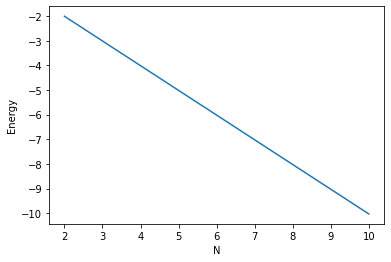

In [88]:
plt.ylabel('Energy')
plt.xlabel('N')
plt.plot(N, energy);

In [108]:
# change N, RealAmplitudes parameters for different experiment setup

construct_ising(2, 1)

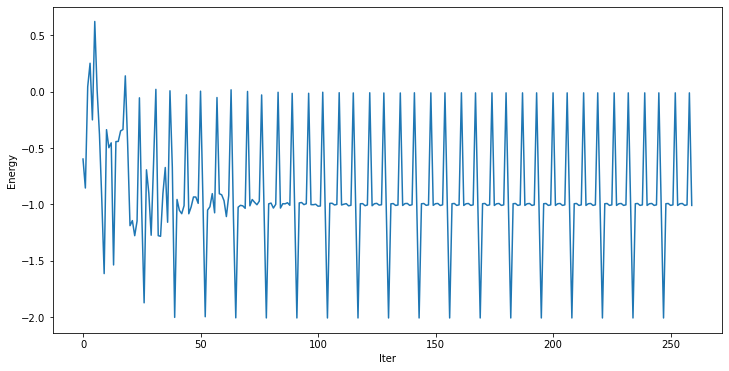

In [112]:
plt.figure(figsize=(12, 6), facecolor='white')
plt.ylabel('Energy')
plt.xlabel('Iter')
plt.plot(intermediate_info['energy'])

In [164]:
energy = {}

for iter in range(2, 11, 1):
  result = construct_ising(iter, 1)
  energy[iter] = intermediate_info['energy']

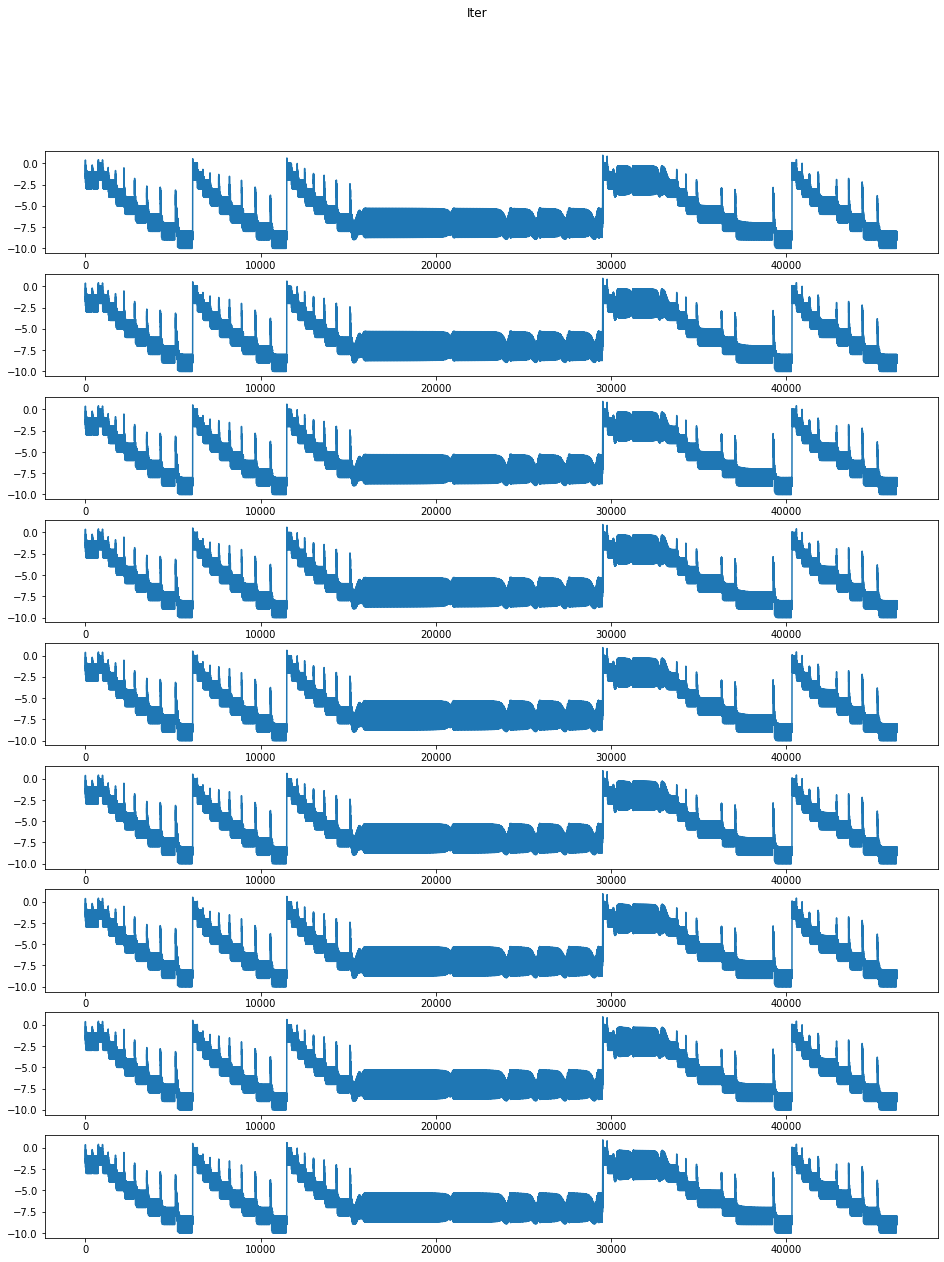

In [166]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize=(16,20))
fig.suptitle('Iter')
ax1.plot(energy[2])
ax2.plot(energy[3])
ax3.plot(energy[4])
ax4.plot(energy[5])
ax5.plot(energy[6])
ax6.plot(energy[7])
ax7.plot(energy[8])
ax8.plot(energy[9])
ax9.plot(energy[10])

plt.show()

#### Setup 2.

The number of the parametrize layers equals the size of the problem $N$.

Example:  for $N=5$, use 5 parametrize layers and 4 entangling layers.

Note: Overparametrization may occur.

In [115]:

construct_ising(3, 3)

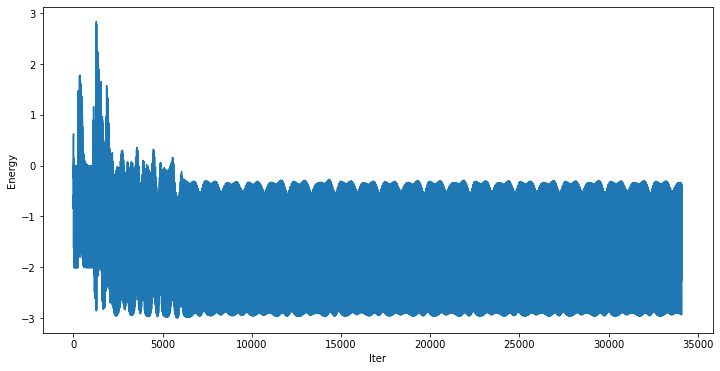

In [116]:
plt.figure(figsize=(12, 6), facecolor='white')
plt.ylabel('Energy')
plt.xlabel('Iter')
plt.plot(intermediate_info['energy'])